In [ ]:
%matplotlib inline

## MOCPy introduction
--------------------------

MOCPy is a python library for creating, manipulate and parse MOCs (Multi-Order Coverage maps).
A MOC describes any arbitrary region on the sky. MOCs can be used to:

- Represent the spatial footprint of a catalog (source and/or image survey).
- Compare the footprints, perform fast intersections, unions, differences.
- Filter an astropy table by discarding all the sources that do not lie in the MOC region.

MOCPy's code can be found on GitHub: https://github.com/cds-astro/mocpy
You can install it: `pip install mocpy`

MOCPy's documentation: https://cds-astro.github.io/mocpy/

In [64]:
import mocpy
from mocpy import MOC
mocpy.__version__

'0.7.4'

## Use astroquery.cds to get spatial footprints (MOCs)
----------------------------------------------------------------------

MOCs can be retrieved from ``astroquery.cds``. ``astroquery.cds`` offers a Python access API  to the MOCServer that stores ~20000 metadata and MOCs of Vizier catalogues and ~500 metadata and MOCs of HiPS image surveys.

``astroquery.cds`` documentation https://astroquery.readthedocs.io/en/latest/cds/cds.html#getting-started

-----------
Let's retrieve:

- The MOC representing the footprint of all the HST combined surveys (see the astroquery.cds documentation, an example is given about that) at the order 8 (i.e. the precision of the MOC, ~13 arcmin)
- The MOC representing the footprint of SDSS9: ID='CDS/P/SDSS9/color'

In [65]:
from regions import CircleSkyRegion
from astropy.coordinates import Angle, SkyCoord
from astroquery.cds import cds

### HST MOC footprint
# We want to retrieve all the HST surveys i.e. the HST surveys covering any region of the sky.
allsky = CircleSkyRegion(SkyCoord(0, 0, unit="deg"), Angle(180, unit="deg"))
hst_moc = cds.query_region(region=allsky,
    # We want a MOCpy object instead of an astropy table
    return_moc=True,
    # The order of the MOC
    max_norder=8,
    # Expression on the ID meta-data
    meta_data="ID=*HST*"
)

### SDSS9
sdss_moc=cds.find_datasets(meta_data="ID=CDS/P/SDSS9/color", return_moc=True)

### GALEX
#galex = cds.find_datasets(meta_data="ID=CDS/P/GALEXGR6/AIS/color", return_moc=True)

In [66]:
type(sdss_moc)

mocpy.moc.moc.MOC

## Manipulate MOCs using MOCPy
---------------------------------------------

``astroquery.cds`` returns mocpy.MOC typed objects. Use MOCPy (see the API of the mocpy.MOC class https://cds-astro.github.io/mocpy/stubs/mocpy.MOC.html#mocpy.MOC) to manipulate them, for example you could:

- Compute their intersection/union
- Serialize them to FITS/json, save them to FITS files
- Filter an astropy table to keep only the sources being on a MOC (the intersection between sdss and the hst surveys).

In [67]:
%time sdss_and_hst_moc = sdss_moc.intersection(hst_moc)
%time sdss_moc.serialize(format='fits')
sdss_moc.write("sdss_moc.fits", format="fits", overwrite=True)

CPU times: user 11.8 ms, sys: 2.7 ms, total: 14.5 ms
Wall time: 14.6 ms
CPU times: user 250 ms, sys: 70.5 ms, total: 321 ms
Wall time: 327 ms


## Plot a MOC using matplotlib
----------------------------------------

Let's see how to plot a MOC using matplotlib.
There is an example of that on the MOCPy's documentation: https://cds-astro.github.io/mocpy/examples/examples.html#loading-and-plotting-the-moc-of-sdss

----------
We use ``matplotlib`` and``MOCPy`` to draw the MOCs of HST and SDSS that we downloaded from `astroquery.cds`.

MOCPy offers an interface to create a WCS:

- centered around a SkyCoord position
- with a specific field of view 
- and a projection (follows this link to see all the projection supported : https://docs.astropy.org/en/stable/wcs/#supported-projections)

MOCPy offers 2 methods taking a ``matplotlib.axe.Axe`` and drawing into it either:

- the full area of the MOC (``mocpy.MOC.fill``)
- only its perimeter (``mocpy.MOC.border``)

These methods accept additional stylistic kwargs defined by ``matplotlib``: https://matplotlib.org/api/_as_gen/matplotlib.patches.PathPatch.html#matplotlib.patches.PathPatch

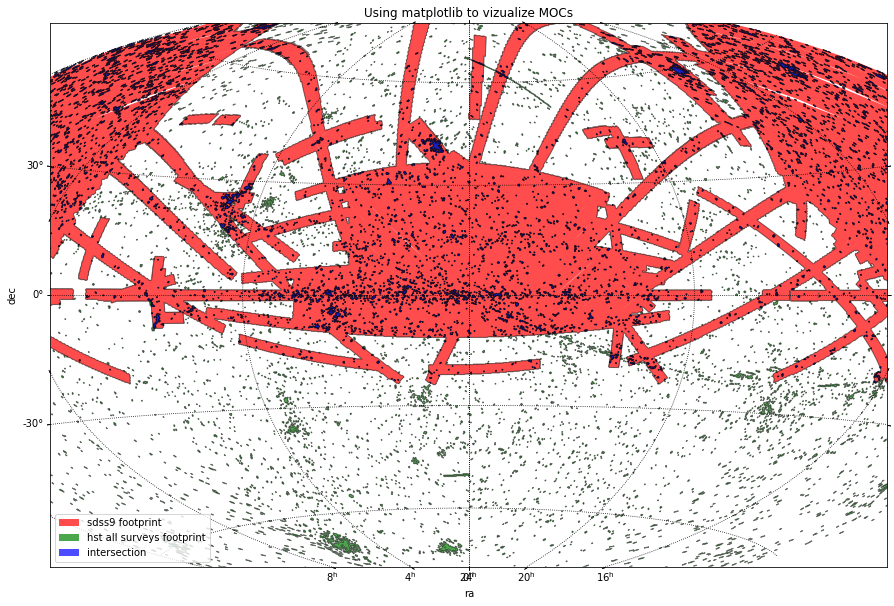

In [68]:
from mocpy import WCS

import astropy.units as u

from matplotlib import path, patches
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))

with WCS(fig, 
         fov=220 * u.deg,
         center=SkyCoord(0, 0, unit='deg', frame='icrs'),
         coordsys='icrs',
         rotation=Angle(0, u.degree),
         projection="AIT") as wcs:
    # Create a matplotlib axe and give it a astropy.wcs.WCS-like object
    ax = fig.add_subplot(1, 1, 1, projection=wcs)

    # Fill the SDSS MOC in red with an opacity of 70%
    sdss_moc.fill(ax=ax, wcs=wcs, edgecolor='r', facecolor='r', linewidth=0, fill=True, alpha=0.7, label="sdss9 footprint")
    # Draw its perimeter in black
    sdss_moc.border(ax=ax, wcs=wcs, color="black", alpha=0.5)
    
    # Fill the HST surveys MOC in green with an opacity of 70%
    hst_moc.fill(ax=ax, wcs=wcs, edgecolor='g', facecolor='g', linewidth=0, fill=True, alpha=0.7, label="hst all surveys footprint")
    # Draw its perimeter in black
    hst_moc.border(ax=ax, wcs=wcs, color="black", alpha=0.5)
    
    # Fill the intersection MOC in blue
    sdss_and_hst_moc.fill(ax=ax, wcs=wcs, edgecolor='b', facecolor='b', linewidth=0, fill=True, alpha=0.7, label="intersection")
    # Draw its perimeter in black
    sdss_and_hst_moc.border(ax=ax, wcs=wcs, color="black", alpha=0.5)

# Usual matplotlib calls
plt.title("Using matplotlib to vizualize MOCs")
plt.xlabel('ra')
plt.ylabel('dec')
plt.legend()
plt.grid(color="black", linestyle="dotted")
plt.show()
plt.close()

## Filter an astropy.Table by a MOC
---------------------------------------------
 
1. Retrieve a catalog table from Vizier (e.g. II/50). Add the columns '_RAJ2000' and '_DEJ2000' to the outputs. MOCPy needs the positions for filtering the table.
2. Filter the table to get only the sources that lie into intersection MOC.

In [69]:
from astroquery.vizier import Vizier

viz = Vizier(columns=['*', '_RAJ2000', '_DEJ2000'])
viz.ROW_LIMIT = -1
# Photometric standard stars (tables II and IV of paper)
tables = viz.get_catalogs('II/50')

print(tables)
table = tables[0]
table

TableList with 1 tables:
	'0:II/50/ubv' with 20 column(s) and 2036 row(s) 


_RAJ2000,_DEJ2000,HD,m_HD,Vmag,u_Vmag,e_Vmag,w_Vmag,B-V,u_B-V,e_B-V,w_B-V,U-B,u_U-B,w_U-B,S,Notes,Simbad,_RA,_DE
deg,deg,,,mag,,mag,,mag,,mag,,mag,,,,,,deg,deg
float64,float64,int32,bytes1,float32,bytes1,float32,float32,float32,bytes1,float32,float32,float32,bytes1,float32,bytes1,bytes23,bytes6,float64,float64
1.3339206,-5.7076183,28,,4.615,,0.007,5.20,1.040,,0.007,5.50,0.89,,2.50,,,Simbad,1.33392,-5.70762
2.3526750,-45.7474261,496,,3.875,,0.005,2.50,1.020,,0.010,2.70,0.86,,1.00,C,,Simbad,2.35267,-45.74743
3.6600664,-18.9328656,1038,,4.430,),0.018,3.50,1.655,,0.006,3.70,2.00,:,3.00,*,,Simbad,3.66007,-18.93287
4.8569769,-8.8239214,1522,,3.550,),0.016,6.20,1.220,),0.014,6.20,1.20,:,4.50,*,,Simbad,4.85698,-8.82392
5.0177506,-64.8747906,1581,,4.220,,--,1.50,0.575,,--,1.50,0.01,,1.00,C,,Simbad,5.01775,-64.87479
6.4377994,-77.2542456,2151,,2.800,,0.006,2.50,0.625,,0.005,1.70,0.10,,1.00,C,,Simbad,6.43780,-77.25425
6.5710456,-42.3059814,2261,,2.395,,0.013,3.50,1.085,,0.004,3.20,0.89,,1.00,C,,Simbad,6.57105,-42.30598
6.5508408,-43.6798294,2262,,3.940,,0.013,2.50,0.170,,0.008,2.70,0.11,,1.00,C,,Simbad,6.55084,-43.67983


In [70]:
idx_inside = sdss_and_hst_moc.contains(table['_RAJ2000'].T * u.deg, table['_DEJ2000'].T * u.deg)
sources_inside = table[idx_inside]
sources_inside

_RAJ2000,_DEJ2000,HD,m_HD,Vmag,u_Vmag,e_Vmag,w_Vmag,B-V,u_B-V,e_B-V,w_B-V,U-B,u_U-B,w_U-B,S,Notes,Simbad,_RA,_DE
deg,deg,,,mag,,mag,,mag,,mag,,mag,,,,,,deg,deg
float64,float64,int32,bytes1,float32,bytes1,float32,float32,float32,bytes1,float32,float32,float32,bytes1,float32,bytes1,bytes23,bytes6,float64,float64
15.7358683,7.8901356,6186,,4.275,,0.012,3.50,0.965,,0.011,3.50,0.69,,2.00,,,Simbad,15.73587,7.89014
25.3578931,5.4876133,10380,,4.445,,0.008,4.70,1.365,,0.006,4.50,1.56,,3.50,,,Simbad,25.35789,5.48761
34.8366364,-2.9776425,14386,,--,),--,--,1.600,,--,0.70,--,,--,,,Simbad,34.83664,-2.97764
49.8404000,3.3701978,20630,,4.845,,0.011,9.70,0.680,,0.006,9.20,0.20,,5.75,,,Simbad,49.84040,3.37020
82.9827500,-7.3015369,36512,,4.615,,0.012,8.70,-0.260,,0.006,8.50,-1.07,,5.00,,,Simbad,82.98275,-7.30154
83.7541956,-6.0092700,36959,,5.665,,--,1.00,-0.220,,--,1.00,-0.91,,1.50,,,Simbad,83.75420,-6.00927
83.7611731,-6.0020269,36960,,4.785,,0.009,2.00,-0.245,,--,1.50,-1.01,,1.75,,,Simbad,83.76117,-6.00203
83.8465175,-4.8383578,37018,,4.590,,0.009,4.00,-0.200,,0.004,4.00,-0.93,,3.50,,,Simbad,83.84652,-4.83836


## Run Aladin-Lite inside a jupyter notebook: ipyaladin
-----------------------------------------------------------------------

Aladin-Lite can be embedded into a jupyter notebook: Follow the readme on GitHub for installing it: https://github.com/cds-astro/ipyaladin

In [ ]:
import ipyaladin as ipyal

In [80]:
aladin= ipyal.Aladin()
aladin

Aladin(options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'overlay_sur…

In [81]:
aladin.target = "messier 51"
aladin.fov = 1

In [82]:
aladin.coo_frame= 'icrs'

Change the image survey, go to https://aladin.unistra.fr/hips/list (Part 1. HiPS sky maps) to test with different image surveys! A list of good HiPS I like for testing:
- P/2MASS/color
- P/PanSTARRS/DR1/color-z-zg-g
- P/SPITZER/color
- P/SDSS9/color
- P/GALEXGR6/AIS/color
- P/Mellinger/color

In [83]:
aladin.survey = 'P/SDSS9/color'

Add a MOC in the aladin-lite view!

In [84]:
# First use MOCPy to serialize our MOC into the JSON format
moc_serialized_json = sdss_and_hst_moc.serialize('json')
aladin.add_moc_from_dict(
    moc_serialized_json, 
    {
        'adaptativeDisplay': True,
        'color': 'blue',
        'opacity': 0.3
    }
)

In [85]:
# Add astropy source tables to the aladin lite viewer
aladin.add_table(sources_inside)
aladin.add_table(table[~idx_inside])

In [86]:
# change the fov and target
aladin.target= "13 04 4.193 -03 34 13.54"
aladin.fov = 11

--------

Pass Python callback functions to Javascript event listeners
-----------

In [87]:
from ipyaladin import Aladin
from ipywidgets import Layout, Box, widgets

aladin = Aladin(layout=Layout(width='100%'), target='M 1', fov=0.2)
aladin

Aladin(fov=0.2, layout=Layout(width='100%'), options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen',…

In [88]:
from astroquery.simbad import Simbad
import astropy.units as u

table = Simbad.query_region("M 1", radius=0.1 * u.deg)
aladin.add_table(table)

In [89]:
def get_ra_dec_data(source):
    return [source['data']['MAIN_ID'], source['ra'], source['dec']]

def hover_source_callback(source):
    return source['data']

# When trigerred, the listeners on the js side of the application will send a
# json object whose parameter data
# will be used by the python functions
# (data is a litteral object on the js side, it will be converted as a
# dictionary object on the Python side)
aladin.add_listener('objectHovered', hover_source_callback)
aladin.add_listener('objectClicked', get_ra_dec_data)

----------

Advanced example
----------------------

Create a rectangular selection using ``ipywidgets`` and gives back the selected sources to the user

In [90]:
from ipyaladin import Aladin
from ipywidgets import Layout, Box, widgets

aladin = Aladin(layout=Layout(width='70%'), target='M 1', fov=0.2)

button = widgets.Button(description="Select")
def on_button_clicked(b):
    aladin.rectangular_selection()

button.on_click(on_button_clicked)
table_info = widgets.HTML(layout=Layout(height='auto', overflow='auto'))

box_layout = Layout(
    display='flex',
    flex_flow='row',
    align_items='stretch',
    width='100%',
    position='relative',
    overflow='hidden',
    height='100vh',
    margin='-100px 0 0 0',
    padding='100px 0 0 0 '
)
box = Box(children=[aladin, button, table_info], layout=box_layout)
box

/usr/local/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:411: DeprecationWarning: Passing unrecoginized arguments to super(Layout).__init__(position='relative').
object.__init__() takes no arguments
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Box(children=(Aladin(fov=0.2, layout=Layout(width='70%'), options=['allow_full_zoomout', 'coo_frame', 'fov', '…

In [91]:
from astroquery.simbad import Simbad
import astropy.units as u

table = Simbad.query_region("M 1", radius=0.1 * u.deg)
aladin.add_table(table)

def process_result(sources):
    s = '<table border="1">'
    s += '<tr><th>MAIN_ID</th><th>RA</th><th>DEC</th></tr>'
    for source in sources:
        s += '<tr><td>%s</td><td>%s</td><td>%s</td></tr>' % (source['data']['MAIN_ID'], source['data']['RA'], source['data']['DEC'])
    s += '</table>'
    table_info.value = s
    
aladin.add_listener('select', process_result)

-------

Useful links
-------------

More info about MOCs:

- It relies on the HEALPix tesselation of the sphere: paper link https://iopscience.iop.org/article/10.1086/427976/fulltext/
- HEALPix implementation in the cdshealpix (`pip install cdshealpix`) https://github.com/cds-astro/cds-healpix-python
- The IVOA reference paper about MOC: http://ivoa.net/documents/MOC/20190903/PR-MOC-1.1-20190903.pdf

Time-MOCs and recently Space-Time MOCs:

- ADASS 2019 presentation from Pierre Fernique: https://www.adass2019.nl/wp-content/uploads/adass-oral/O2-3-fernique-stmoc-behind-the-scene.pdf
- IVOA notebook about ST-MOCs in MOCPy: https://github.com/cds-astro/mocpy/blob/master/notebooks/Space%20%26%20Time%20coverages.ipynb